In [ ]:
import xarray as xr
!pip install bambi
import bambi as bmb
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns


Player ratings in soccer give us insight on how impactful a player is to a game. Its a hollistic review of a player's performance in a match fit into a number. Players start at a 6.0 rating at the beginning of a match and gain or lose points based on how they perform.

As a kid, I was surprised to see iconic midfielders have such little assists. I had thought that they were the players that pass the ball inside the box for their teammates to blast into the goal. This made me wonder: If assists aren't the main metric for deciding if a midfielder is good or not, what is? As such, I will be analyzing the ratings and stats of a bunch of midfielders and seeing which predictors (statlines) best define how well they do in a match.

(Only pulling midfielders with 60+ minutes played)

In [2]:
alr = pd.read_csv("https://raw.githubusercontent.com/AbdurSharif/data-science-1/refs/heads/main/midfielder.csv")

#full dataset includes everything including shooting percentage, tackles, etc, but since we're only focusing on midfielders, I deleted that stuff before hand
#remove some stuff we dont need (g/a = goals + assists, which help combine and simplify the study)
#accurate longballs too similar to accurate passes ngl
del alr['assists']
del alr['accurate_long_balls']
del alr['goals']


alr


,accurate_passes,goal_con,fouls,rating
0,57,3,0,9.3
1,46,3,2,9.2
2,43,3,2,9.1
3,28,3,1,8.9
4,36,3,1,9.2
...,...,...,...,...
719,62,0,1,7.7
720,35,0,2,7.0
721,51,0,1,7.3
722,43,0,1,6.5


# Predictors Used -
I've decided on 3 main predictors to use:


*   Goal Contributions: The sum of the # of goals and assists a player gets in a game. I began my study thinking that the number of goals and (especially) assists a midfielder makes determines how well they play in a match, however historically famous midfielders didn't have that many assists. Because of this, I'd still like to include it in my data, but use other predictors alongside it. Because my data set only has players that have 0, 1, 2, or 3 goal contributions, I've decided to make it a categorical predictor. Thats because not only does that make the data not discrete, but a player's rating in a game shoots up drastically per goal contribution they make. Having seperate curves for each # of goal contribution will make the data clearer.
*   Accurate Passes: A midfielder's primary job is to connect the defense and attack of the team through passes, keeping posession of the ball and making key passes. Because of this, I hypothesize that accurate passes are crucial to a midfielder's rating.
*   Fouls: Fairplay is always an important part of any player's rating, and a repeat number of fouls could tank your rating, even if you contribute to many of the team's goals. Including this predictor can potentially make the data clearer.

---


# Model 1
Predicts rating with accurate passes and goal contributions (with goal contribitions as a categorical predictor)


Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='accurate_passes', ylabel='rating'>], dtype=object))

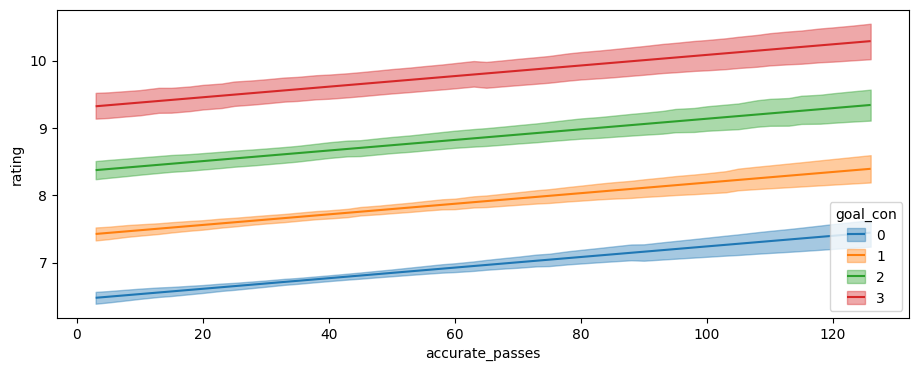

In [62]:
model_mid = bmb.Model("`rating` ~ `accurate_passes` + goal_con", data=alr)
idata_mid = model_mid.fit(idata_kwargs={'log_likelihood': True})
bmb.interpret.plot_predictions(model_mid,
                               idata_mid,
                                ["accurate_passes",  "goal_con"], fig_kwargs={"figsize":(11, 4)})


# Model 2
Predicts rating with accurate passes and goal contributions (with goal contributions as a hierarchy)


Output()

Output()

ERROR:pymc.stats.convergence:There were 183 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='accurate_passes', ylabel='rating'>], dtype=object))

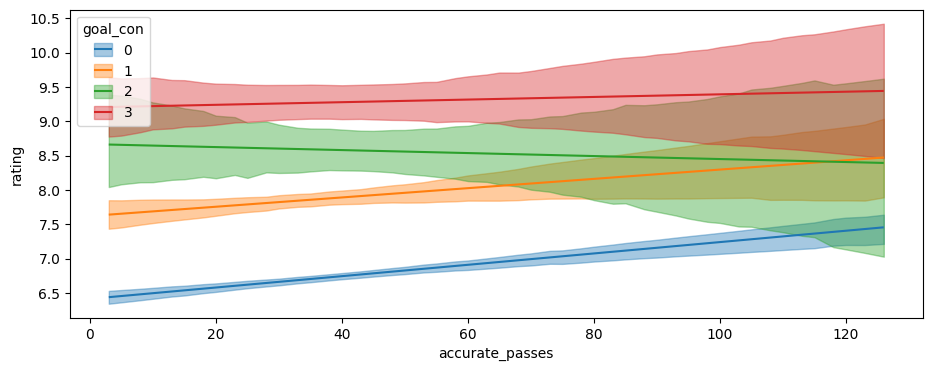

In [63]:
#2
model_mid_h = bmb.Model("`rating` ~ (`accurate_passes`|goal_con)", data=alr)
idata_mid_h = model_mid_h.fit(idata_kwargs={'log_likelihood': True})

bmb.interpret.plot_predictions(model_mid_h,
                               idata_mid_h,
                               ["accurate_passes","goal_con"],
                               fig_kwargs={"figsize":(11, 4)})




# Model 3
Predicts rating with accurate passes and goal contributions (with goal contributions interacting with accurate passes)


Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='accurate_passes', ylabel='rating'>], dtype=object))

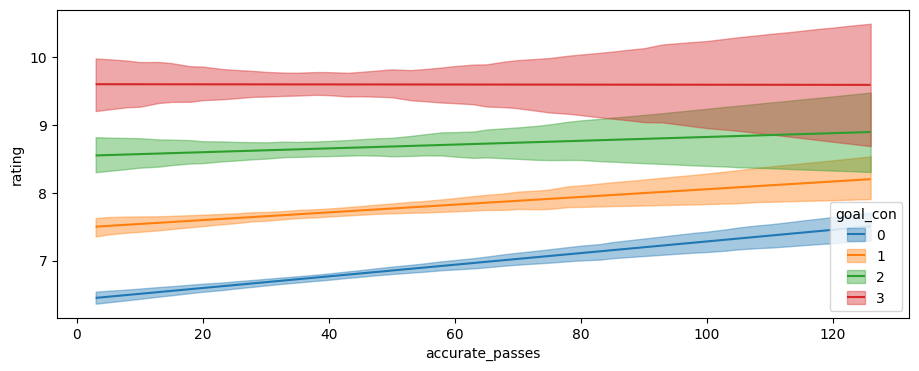

In [64]:
model_3 = bmb.Model("`rating` ~ `accurate_passes` + `goal_con` + `accurate_passes`:`goal_con`", data=alr)
idata_3 = model_3.fit(idata_kwargs={'log_likelihood': True})
bmb.interpret.plot_predictions(model_3,
                               idata_3,
                               ["accurate_passes","goal_con"],
                               fig_kwargs={"figsize":(11, 4)})



# Model 4
Predicts rating with accurate passes, goal contributions, fouls, and interactions between all three predictors


Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x650 with 4 Axes>,
 array([<Axes: title={'center': 'goal_con = 0'}, xlabel='accurate_passes', ylabel='rating'>,
        <Axes: title={'center': 'goal_con = 1'}, xlabel='accurate_passes', ylabel='rating'>,
        <Axes: title={'center': 'goal_con = 2'}, xlabel='accurate_passes', ylabel='rating'>,
        <Axes: title={'center': 'goal_con = 3'}, xlabel='accurate_passes', ylabel='rating'>],
       dtype=object))

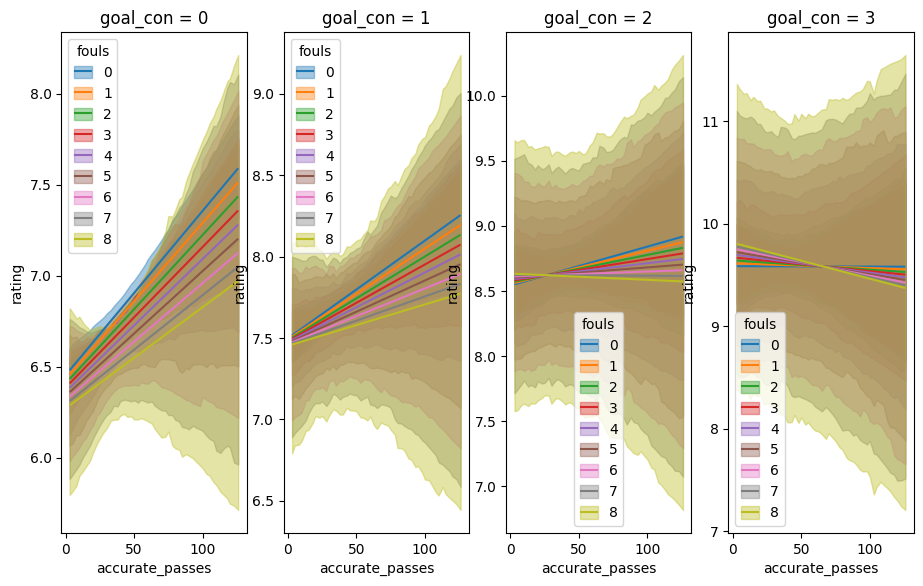

In [49]:
model_4 = bmb.Model("`rating` ~ `accurate_passes` + `fouls` + `goal_con` + `accurate_passes`:`fouls` + `accurate_passes`:`goal_con` + `fouls` : `goal_con`", data=alr)
idata_4 = model_4.fit(idata_kwargs={'log_likelihood': True})
bmb.interpret.plot_predictions(model_4,
                               idata_4,
                               ["accurate_passes","fouls","goal_con"],
                               fig_kwargs={"figsize":(11, 6.5)})



# Model 5
Predicts rating with accurate passes, goal contributions, fouls, with an interaction between fouls and goal contributions.


Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x650 with 4 Axes>,
 array([<Axes: title={'center': 'goal_con = 0'}, xlabel='accurate_passes', ylabel='rating'>,
        <Axes: title={'center': 'goal_con = 1'}, xlabel='accurate_passes', ylabel='rating'>,
        <Axes: title={'center': 'goal_con = 2'}, xlabel='accurate_passes', ylabel='rating'>,
        <Axes: title={'center': 'goal_con = 3'}, xlabel='accurate_passes', ylabel='rating'>],
       dtype=object))

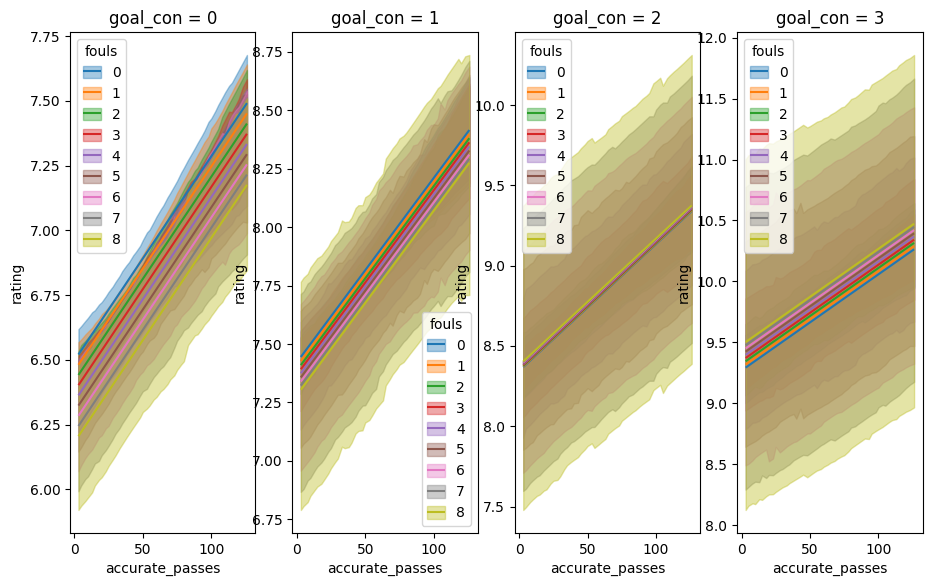

In [44]:
model_5 = bmb.Model("`rating` ~ `accurate_passes` + `fouls` + `goal_con` + `fouls` : `goal_con`", data=alr)
idata_5 = model_5.fit(idata_kwargs={'log_likelihood': True})
bmb.interpret.plot_predictions(model_5,
                               idata_5,
                               ["accurate_passes","fouls","goal_con"],
                               fig_kwargs={"figsize":(11, 6.5)})



<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

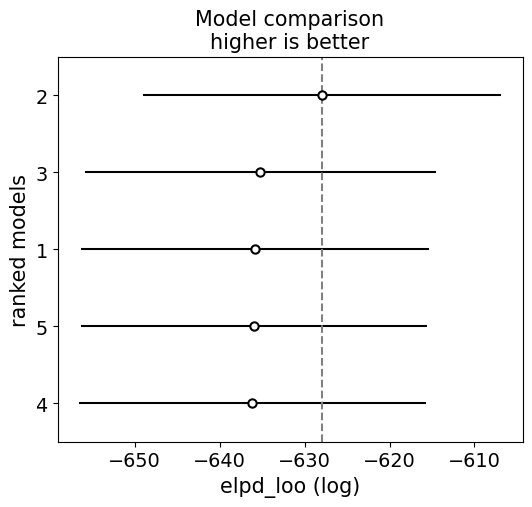

In [57]:
cmp = az.compare({"1":idata_mid,"2":idata_mid_h, "3":idata_3, "4":idata_4, "5": idata_5, })

az.plot_compare(cmp)

We see that model 2 is has the highest elpd_loo value! Analyzing the model, we see the clear conclusion (which is present in all of the other models as well) is that although passes are important in a midfielder's rating, goal contributions heavily outweigh that importance, and as you make more goal contributions, the less your passes matter. On model 2's 0 goal contribution line, we see we have the largest positive correlation between # of passes and rating, while the 3 goal contribution line shows that when you make so many goals, passing well or not doesn't matter.

### **Why is this the case?**
The sport's objective is to score goals. Whoever scores more wins, after all. And so, if a midfielder directly causes the team to win in this way, they're rating will be undoubtably higher. Additionally, making mistakes in soccer is okay as long as you can make up for them in a way to make your team win. So a low accurate passing rate can be looked over if a player contributes 3+ times to a goal.

Another theory is that while a player's rating is customized based on their position, seeing as goalkeepers aren't penalized for not scoring any goals, the rating is a universal measure at the end of the day. Having a more midfielder-specific rating system could value passes, fouls, tackles, etc more.

---
# PPC!



<Axes: xlabel='rating'>

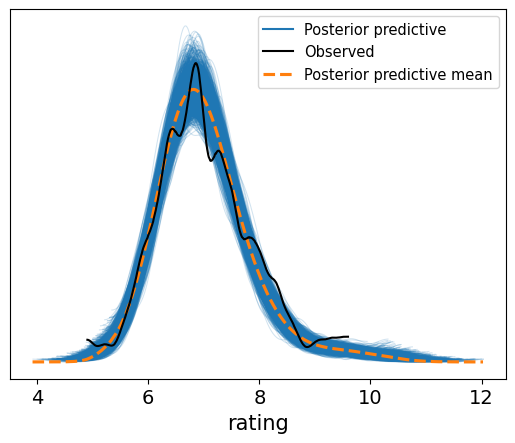

In [52]:
model_mid_h.predict(idata_mid_h, kind='response')
az.plot_ppc(idata_mid_h)

This is a PPC of model 2, the model that returned the highest elpd_loo value, however all the other models had identical PPCs, so I'll just show you one of them. The PPC predicts the data well enough, where the general shape is followed, however some more complicated shapes within the original data *can't* be modeled, like the triple peak. Overall I'd say this is a good prediction for the scope of the class.